In [2]:
import coremltools
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [14]:
#version 4.0
coreml_model = coremltools.convert(unet_model, inputs=[coremltools.ImageType(scale=1.0/255, channel_first=False)], input_names=['unet_input'], output_names=['Identity'])

# coreml_model.input_description['unet_input'] = 'Frame from camera.'
# coreml_model.output_description['Identity'] = 'Mask.'

coreml_model.save("unet_model.mlmodel")

AttributeError: module 'coremltools' has no attribute 'convert'

In [16]:
#version 3.4
coreml_model = coremltools.converters.keras.convert("unet_model.h5", image_scale=1.0/255, image_input_names=['unet_input'], input_names=['unet_input'], output_names=['Identity'], use_float_arraytype=True)

coreml_model.input_description['unet_input'] = 'Frame from camera.'
coreml_model.output_description['Identity'] = 'Direction.'

coreml_model.save("blindpilot.mlmodel")

0 : unet_input, <keras.engine.input_layer.InputLayer object at 0x7fb85c053510>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7fb85c0534d0>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x7fb85d75efd0>
3 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7fb857742bd0>
4 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x7fb85d7a0050>
5 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x7fb857742d50>
6 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7fb857742fd0>
7 : concatenate_1, <keras.layers.merge.Concatenate object at 0x7fb85774b110>
8 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7fb85774b1d0>
9 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x7fb85d7a0150>
10 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x7fb85774b410>
11 : conv2d_4__activation__, <keras.layers.core.Activation object at 0x7fb85cf4bb90>
12 : max_pooling2d_4, <keras.layers.poolin

In [13]:
import coremltools.proto.FeatureTypes_pb2 as ft 

spec = coreml_model.get_spec()
spec_layers = getattr(spec,spec.WhichOneof("Type")).layers
last_layer = spec_layers[-1]
 
new_layer = spec_layers.add()
new_layer.name = 'convert_to_image'
 
new_layer.activation.linear.alpha = 255

new_layer.activation.linear.beta = 0
 
new_layer.input.append(last_layer.output[0])
 
new_layer.output.append('image_output')

output = next(x for x in spec.description.output if x.name==last_layer.output[0])
 
# Update it to use the new layer as output
output.name = new_layer.name

output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('GRAYSCALE')
output.type.imageType.height = 224
output.type.imageType.width = 224

coremltools.utils.save_spec(spec, "unet_model.mlmodel")

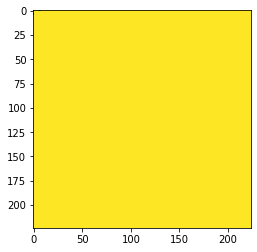

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open('frame0116.png')

prediction = coreml_model.predict({"unet_input": image})
plt.imshow(prediction['Identity'].reshape(224, 224))

In [43]:
import coremltools.proto.FeatureTypes_pb2 as ft 

spec = coremltools.utils.load_spec("with_alpha.mlmodel")
output = spec.description.output[0]

output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('GRAYSCALE')
output.type.imageType.height = 224
output.type.imageType.width = 224

coremltools.utils.save_spec(spec, "unet_model.mlmodel")